# Deploy a pretrained HuggingFace InstructPix2Pix (Diffuser) Model into a SageMaker Endpoint

HuggingFace Diffusers provide pretrained vision and audio diffusion models, and serves as a modular toolbox for inference and training. 

Amazon SageMaker is a fully managed service that provides developers and data scientists with the ability to build, train, and deploy machine learning (ML) models quickly. Amazon SageMaker removes the heavy lifting from each step of the machine learning process to make it easier to develop high-quality models. The SageMaker Python SDK provides open source APIs and containers that make it easy to train and deploy models in Amazon SageMaker with several machine learning and deep learning frameworks.

HuggingFace models, which have a corresponding HuggingFace task, can be deployed to SageMaker as a `HuggingFaceModel` object, as described in [the documentation](https://huggingface.co/docs/sagemaker/inference). Yet, not all the models have a corresponding HuggingFace task.

In this notebook, we will use an approach to deploy any model from HuggingFace hub by taking files from a Git repo. As an example, we will use a pretrained instruction-based image editing model (https://huggingface.co/timbrooks/instruct-pix2pix). To do this, we will implement a custom entry point `inference.py` that will initiate the model in a SageMaker container and handle inference requests, which contain multimodal input (text prompt and image data).

We will execute the following steps:

- Download a HuggingFace model to the local file system with Git LFS.
- Tar-gzip the model and config files, and upload `model.tar.gz` to an S3 bucket.
- Deploy the model to a SageMaker Endpoint and make an inference request.
- Optionally, use inference recommender to check how different instance types perform as an endpoint.
- Optionally, cleanup.

Note that this notebook was adopted from another SageMaker example of [Pretrained PyTorch BERT model for sentiment analysis](https://github.com/aws/amazon-sagemaker-examples/blob/main/advanced_functionality/pytorch_deploy_pretrained_bert_model/pytorch_deploy_pretrained_bert_model.ipynb). Our example is different, because it doesn't require the model to be loaded with HuggingFace library into memory before saving it and sending for inference to SageMaker Endpoint.

For a step by step, hands-on learning experience about deploying other large generative AI models, please check: https://catalog.us-east-1.prod.workshops.aws/workshops/bb62b5d7-313f-4733-88cd-9c1aa41c724d/en-US/

Let's start by creating a SageMaker session and specifying:

- The S3 bucket and prefix that you want to use for the model data.  This should be within the same region as the notebook instance, training, and hosting.
- The IAM role arn used to give hosting access to your data. See the documentation for how to create these.  Note, if you want to use another role, please replace the `sagemaker.get_execution_role()` with the appropriate full IAM role arn string.

In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_region_name
model_prefix = "timbrooks/instruct-pix2pix"
role = sagemaker.get_execution_role()

## Download the `InstructPix2Pix` model artifacts from HuggingFace hub

We install Git LFS to handle large files in the git repository. Then we clone the repository locally to save the pre-trained model on the file system. 

In [3]:
!apt-get -qq update
!apt-get -qq install -y curl git-lfs

In [4]:
!git lfs install

Git LFS initialized.


We skip downloading `safetensors` and `ckpt` files as they are heavyweight and not needed to deploy the model into SageMaker.

In [5]:
!GIT_LFS_SKIP_SMUDGE=1 git clone --depth 1 https://huggingface.co/timbrooks/instruct-pix2pix
!git -C instruct-pix2pix/ lfs pull --exclude='*.safetensors,*.ckpt'

Cloning into 'instruct-pix2pix'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 32 (delta 1), reused 29 (delta 1), pack-reused 0
Unpacking objects: 100% (32/32), done.


*Note:* As of the date of writing of this example, `git clone` command with LFS had [memory constraints](https://github.com/git-lfs/git-lfs/issues/3524). To be able to run this example on `ml.t3.medium` instance that has only 4 GB of RAM, we split clone the command in two.

Cleanup the LFS pointers to the skipped files.

In [6]:
!find ./instruct-pix2pix -name "*.ckpt" -type f -delete
!find ./instruct-pix2pix -name "*.safetensors" -type f -delete

SageMaker does not need git information. Cleanup the git files to save disk space.

In [7]:
!rm -r ./instruct-pix2pix/.git
!rm ./instruct-pix2pix/.gitattributes

## Package the pre-trained model and upload it to S3

Now you can see that there is a pretrained HuggingFace model under `instruct-pix2pix/` directory by listing the files in it, and you can upload it to S3.

In [8]:
!cp -r ./code/ ./instruct-pix2pix/

In [9]:
!ls -rtlh ./instruct-pix2pix/

total 40K
-rw-r--r-- 1 sagemaker-studio root 1.3K Apr 17 09:24 README.md
drwxr-xr-x 2 sagemaker-studio root 6.0K Apr 17 09:24 feature_extractor
-rw-r--r-- 1 sagemaker-studio root  616 Apr 17 09:24 model_index.json
drwxr-xr-x 2 sagemaker-studio root 6.0K Apr 17 09:24 scheduler
drwxr-xr-x 2 sagemaker-studio root 6.0K Apr 17 09:24 tokenizer
drwxr-xr-x 2 sagemaker-studio root 6.0K Apr 17 09:28 safety_checker
drwxr-xr-x 2 sagemaker-studio root 6.0K Apr 17 09:28 text_encoder
drwxr-xr-x 2 sagemaker-studio root 6.0K Apr 17 09:28 vae
drwxr-xr-x 2 sagemaker-studio root 6.0K Apr 17 09:28 unet
drwxr-xr-x 3 sagemaker-studio root 6.0K Apr 17 09:28 code


In [10]:
!tar --use-compress-program='gzip --fast' -cvf ./model.tar.gz -C ./instruct-pix2pix/ .

./
./model_index.json
./safety_checker/
./safety_checker/pytorch_model.bin
./safety_checker/config.json
./text_encoder/
./text_encoder/pytorch_model.bin
./text_encoder/config.json
./vae/
./vae/diffusion_pytorch_model.bin
./vae/config.json
./unet/
./unet/diffusion_pytorch_model.bin
./unet/config.json
./README.md
./code/
./code/requirements.txt
./code/.ipynb_checkpoints/
./code/.ipynb_checkpoints/inference-checkpoint.py
./code/inference.py
./tokenizer/
./tokenizer/tokenizer_config.json
./tokenizer/merges.txt
./tokenizer/special_tokens_map.json
./tokenizer/vocab.json
./feature_extractor/
./feature_extractor/preprocessor_config.json
./scheduler/
./scheduler/scheduler_config.json


In [11]:
pretrained_model_data = sagemaker_session.upload_data(
    path="model.tar.gz", bucket=bucket, key_prefix=model_prefix
)

In [12]:
!pygmentize instruct-pix2pix/code/inference.py

import json

import logging

import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

from PIL import Image
import base64
from io import BytesIO

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

JSON_CONTENT_TYPE = 'application/json'


def model_fn(model_dir, context):
    logger.debug("model_fn: Creating model")
    pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(pretrained_model_name_or_path=model_dir,
                                                                  torch_dtype=torch.float16)
    # distribute instantiated models among different gpus
    gpu_id = str(context.system_properties.get("gpu_id"))
    logger.debug("gpu_id:" + gpu_id)
    pipe.to("cuda:" + gpu_id)
    
    pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
    logger.debug("model_fn: Model created and served via GPU: " + gpu_id)
    return pipe


def input_fn(serialized_input_data, content_ty

In [13]:
!pygmentize instruct-pix2pix/code/requirements.txt

# Requirements taken from https://huggingface.co/timbrooks/instruct-pix2pix
diffusers
accelerate
#safetensors  # not needed in this example
transformers


In [14]:
from sagemaker.pytorch.model import PyTorchModel

pytorch_model = PyTorchModel(
    model_data=pretrained_model_data,
    role=role,
    framework_version="1.12",
    py_version="py38",
    source_dir="instruct-pix2pix/code",
    entry_point="inference.py",
)

In [15]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.g5.xlarge")

----------------!

Since in the `input_fn` we declared that the incoming requests are JSON-encoded, we need to use a `JSONSerializer`.

Also, we return a base64 string. So, we need to use a `StringDeserializer` to parse the response.

In [16]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import StringDeserializer

predictor.serializer = JSONSerializer()
predictor.deserializer = StringDeserializer()

## Test the model

Using few samples, you can now invoke the SageMaker endpoint to get predictions. Note that we have a multimodal input as the model expects a prompt message as well as an image.
So, we will pack the prompt and the image into a JSON object. For that we need to base64-encode the image.

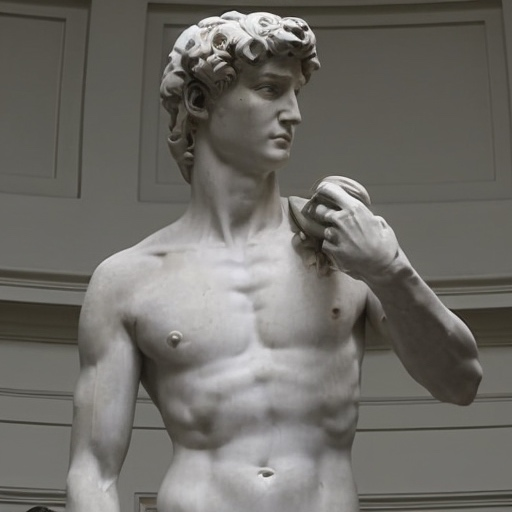

In [17]:
from PIL import Image, ImageOps
import requests

url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"


def download_image(image_url):
    result = Image.open(requests.get(image_url, stream=True).raw)
    result = ImageOps.exif_transpose(result)
    result = result.convert("RGB")
    return result


image = download_image(url)
image

In [18]:
import base64
from io import BytesIO

buffered = BytesIO()
image.save(buffered, format="PNG")
img_str = base64.b64encode(buffered.getvalue())
base64_string = img_str.decode("latin1")

In [19]:
data = {"inputs": {"prompt": "turn him into cyborg", "image": base64_string}}

In [20]:
prediction_result = predictor.predict(data)

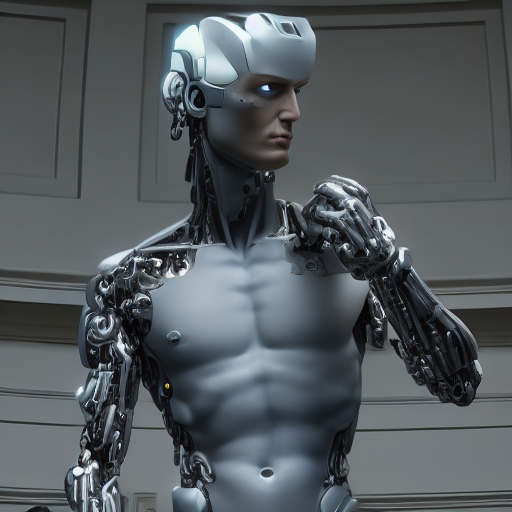

In [21]:
f = BytesIO(base64.b64decode(prediction_result))
img = Image.open(f)
img

## Optional: Use Inference Recommender to Select the Best Instance

Inference Recommender uses information about your ML model to recommend the best instance types and endpoint configurations for deployment. 

As the first step, we fetch the images the inference-recommender should use in the multimodal input. 

In [22]:
# Save image(s) to use for payload generation
!aws s3 cp s3://sagemaker-sample-files/datasets/image/pets ./images/pets --recursive

download: s3://sagemaker-sample-files/datasets/image/pets/british_blue_shorthair_cat.jpg to images/pets/british_blue_shorthair_cat.jpg
download: s3://sagemaker-sample-files/datasets/image/pets/english_cocker_spaniel_dog.jpg to images/pets/english_cocker_spaniel_dog.jpg
download: s3://sagemaker-sample-files/datasets/image/pets/shiba_inu_dog.jpg to images/pets/shiba_inu_dog.jpg
download: s3://sagemaker-sample-files/datasets/image/pets/boxer_dog.jpg to images/pets/boxer_dog.jpg


Now, we can create the multimodal payloads using the downloaded images and a prompt. The inference recommender will do random sampling to use the payloads in load tests. Note that we resize the images to 512x512 to load test based on the same size. Additionally, we only use one prompt message in this example. Make sure that your sample-payloads used by the inference recommender have a similar distribution of data to the different payloads expected in production.

In [23]:
from io import BytesIO
import json


def create_sample_payload(images_directory):
    for image_path in os.listdir(images_directory):
        input_path = os.path.join(images_directory, image_path)
        print(input_path)
        img = Image.open(input_path)
        img = img.resize((512, 512))  # resizing to load test based on the same size

        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue())
        base64_string = img_str.decode("latin1")
        payload = {"inputs": {"prompt": "turn him into cyborg", "image": base64_string}}
        output_path = os.path.join("sample-payload", image_path.replace(".", "_") + "_payload.txt")
        with open(output_path, "w") as file:
            file.write(json.dumps(payload))

In [24]:
!mkdir ./sample-payload
import os

create_sample_payload("./images/pets")

./images/pets/boxer_dog.jpg
./images/pets/shiba_inu_dog.jpg
./images/pets/british_blue_shorthair_cat.jpg
./images/pets/english_cocker_spaniel_dog.jpg


In [25]:
payload_archive_name = "payload.tar.gz"
!cd ./sample-payload/ && tar czvf ../{payload_archive_name} *

boxer_dog_jpg_payload.txt
british_blue_shorthair_cat_jpg_payload.txt
english_cocker_spaniel_dog_jpg_payload.txt
shiba_inu_dog_jpg_payload.txt


In [26]:
sample_payload_url = sagemaker.Session().upload_data(
    payload_archive_name, bucket=bucket, key_prefix=model_prefix + "/inference-recommender"
)

Provide domain and model related information to Inference Recommender:

Example ML Domains: COMPUTER_VISION, NATURAL_LANGUAGE_PROCESSING, MACHINE_LEARNING
Example ML Tasks: CLASSIFICATION, REGRESSION, OBJECT_DETECTION, OTHER
Note: Select the task that is the closest match to your model. Chose OTHER if none apply.

Use list_model_metadata API to fetch the list of available models. This will help you to pick the closest model for better recommendation.

We have a multimodal ML model. Here, we take natural language processing as approximation.

In [27]:
ml_domain = "MACHINE_LEARNING"
ml_task = "OTHER"
ml_framework = "PYTORCH"
framework_version = "1.12"

In [28]:
from sagemaker import image_uris

inference_image = image_uris.retrieve(
    framework="pytorch",
    region=region,
    version=framework_version,
    py_version="py38",
    instance_type="ml.p3.8xlarge",
    image_scope="inference",
)

print(inference_image)

763104351884.dkr.ecr.eu-central-1.amazonaws.com/pytorch-inference:1.12-gpu-py38


In [29]:
import time
import boto3

client = boto3.client("sagemaker", region)

model_package_group_name = "instruct-pix2pix-" + str(round(time.time()))
print(model_package_group_name)
model_package_group_response = client.create_model_package_group(
    ModelPackageGroupName=str(model_package_group_name),
    ModelPackageGroupDescription="instruct-pix2pix model group",
)

instruct-pix2pix-1681725500


In [30]:
model_package_version_response = client.create_model_package(
    ModelPackageGroupName=str(model_package_group_name),
    ModelPackageDescription="instruct-pix2pix Inference Recommender Demo",
    Domain=ml_domain,
    Task=ml_task,
    SamplePayloadUrl=sample_payload_url,
    InferenceSpecification={
        "Containers": [
            {
                "ContainerHostname": "pytorch",
                "Image": inference_image,
                "ModelDataUrl": pretrained_model_data,
                "Framework": ml_framework,
                "FrameworkVersion": framework_version,
                "Environment": {
                    "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
                    "SAGEMAKER_PROGRAM": "inference.py",
                    "SAGEMAKER_REGION": region,
                    "SAGEMAKER_SUBMIT_DIRECTORY": pretrained_model_data,
                },
            },
        ],
        "SupportedRealtimeInferenceInstanceTypes": [
            "ml.g4dn.xlarge",
            "ml.g4dn.12xlarge",
            "ml.g5.xlarge",
            "ml.p3.2xlarge",
            "ml.p3.8xlarge",
        ],
        "SupportedContentTypes": ["application/json"],
        "SupportedResponseMIMETypes": ["application/json"],
    },
)

In [31]:
import datetime

default_job = "instrpx2px-" + datetime.datetime.now().strftime("%d-%H-%M-%S")
default_response = client.create_inference_recommendations_job(
    JobName=str(default_job),
    JobDescription="instruct-pix2pix Inference Basic Recommender Job",
    JobType="Default",
    RoleArn=role,
    InputConfig={"ModelPackageVersionArn": model_package_version_response["ModelPackageArn"]},
)

The inference recommender job provides multiple endpoint recommendations in its result. The recommendation includes `InstanceType`, `InitialInstanceCount`, `EnvironmentParameters` which includes tuned parameters for better performance. We also include the benchmarking results like `MaxInvocations`, `ModelLatency`, `CostPerHour` and `CostPerInference` for deeper analysis. The information provided will help you narrow down to a specific endpoint configuration that suits your use case.

In [32]:
%%time

import boto3

client = boto3.client("sagemaker", region)

ended = False
while not ended:
    inference_recommender_job = client.describe_inference_recommendations_job(
        JobName=str(default_job)
    )
    if inference_recommender_job["Status"] in ["COMPLETED", "STOPPED", "FAILED"]:
        ended = True
    else:
        print("Inference recommender job in progress")
        time.sleep(60)

if inference_recommender_job["Status"] == "FAILED":
    print("Inference recommender job failed ")
    print("Failed Reason: {}".inference_recommender_job["FailedReason"])
else:
    print("Inference recommender job completed")

Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference recommender job in progress
Inference re

In [33]:
import pandas as pd

data = [
    {**x["EndpointConfiguration"], **x["ModelConfiguration"], **x["Metrics"]}
    for x in inference_recommender_job["InferenceRecommendations"]
]
df = pd.DataFrame(data)
dropFilter = df.filter(["VariantName"])
df.drop(dropFilter, inplace=True, axis=1)
pd.set_option("max_colwidth", 400)

In [38]:
df[
    [
        "EndpointName",
        "InstanceType",
        "CostPerHour",
        "CostPerInference",
        "MaxInvocations",
        "ModelLatency",
    ]
].sort_values(by=["MaxInvocations"], ascending=False).head()

,EndpointName,InstanceType,CostPerHour,CostPerInference,MaxInvocations,ModelLatency
4,instrpx2px-17-09-58-20-0jbT5IlfAMMBMB0lLIOJ,ml.p3.8xlarge,18.350,0.001560,196,2290
3,instrpx2px-17-09-58-20-rxMbAZYgZTasONH6P9OK,ml.g4dn.12xlarge,6.112,0.001395,73,6399
2,instrpx2px-17-09-58-20-dcoD4Li1AY4wl3Y7gMaD,ml.p3.2xlarge,4.779,0.001593,50,3495
0,instrpx2px-17-09-58-20-nYvxV2e683iycCe8OMhb,ml.g5.xlarge,1.761,0.000699,42,4344
1,instrpx2px-17-09-58-20-mUefeiH1KY71jTxe2x2N,ml.g4dn.xlarge,0.921,0.000853,18,9791


Note how the new generation instances such as G5 are outperforming the G4 instances of the previous generation!

Cleanup Inference Recommender related artifacts

In [ ]:
!rm -rf ./sample-payload
!rm -rf ./images
!rm payload.tar.gz
!aws s3 rm --quiet $sample_payload_url

## Clean up

Endpoints should be deleted when no longer in use, since they're billed by time deployed, according to the [SageMaker pricing page](https://aws.amazon.com/sagemaker/pricing/).

In [ ]:
predictor.delete_endpoint()

Also remove the cloned directory and the model object.

In [ ]:
!rm -rf ./instruct-pix2pix

In [ ]:
!rm model.tar.gz

In [ ]:
!aws s3 rm --quiet $pretrained_model_data